In [ ]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'

import shutup
shutup.please()

from rich.pretty import pprint

from jax import random
import jax.numpy as jnp
import numpy as np

# RL 
import gymnasium
import ogbench
import ogbench.online_locomotion.wrappers
from envs.ogbench.ant_utils import MazeVizWrapper

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
plt.style.use(['science', 'notebook'])

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


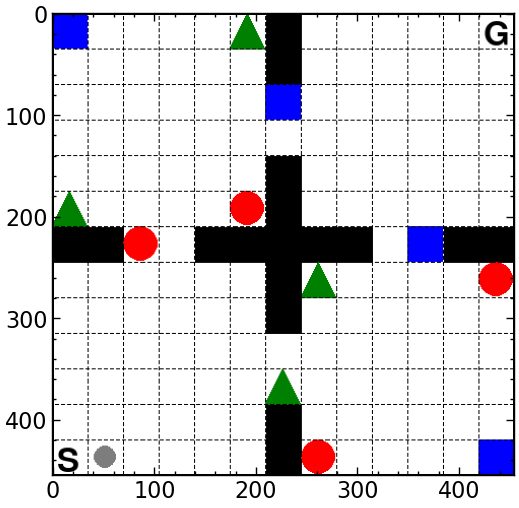

In [12]:
from envs.grid_custom.fourrooms import FourRoom

env = FourRoom(render_mode='rgb_array')
obs, info = env.reset()
env.step(2)
plt.imshow(env.render())

In [ ]:
# Define parameters
num_objects = 12  # Number of objects (n_o)
grid_size = 10    # 10x10 grid for RBFs
sigma = 0.1       # Width of Gaussian RBFs

# Generate centers for the RBFs (10x10 grid)
centers = jnp.array([(x, y) for x in jnp.linspace(0, 1, grid_size) 
                              for y in jnp.linspace(0, 1, grid_size)])

def rbf_features(position, centers, sigma):
    """
    Compute the RBF features for a given position.
    
    Args:
        position: A tuple (s_x, s_y) representing the agent's position.
        centers: A 2D array of RBF centers.
        sigma: The width of the Gaussian RBFs.
    
    Returns:
        A 1D array of RBF feature activations.
    """
    sx, sy = position
    distances = jnp.sum((jnp.array([sx, sy]) - centers) ** 2, axis=1)
    return jnp.exp(-distances / sigma)

def inventory_features(objects_picked):
    """
    Compute the inventory features.
    
    Args:
        objects_picked: A binary array of shape (n_o,) indicating which objects have been picked.
    
    Returns:
        A 1D array of inventory features.
    """
    return objects_picked  # Directly return the binary vector

def construct_feature_vector(position, objects_picked, centers, sigma):
    """
    Construct the full feature vector phi(s).
    
    Args:
        position: A tuple (s_x, s_y) representing the agent's position.
        objects_picked: A binary array of shape (n_o,) indicating which objects have been picked.
        centers: A 2D array of RBF centers.
        sigma: The width of the Gaussian RBFs.
    
    Returns:
        A 1D array representing the feature vector phi(s).
    """
    phi_p = rbf_features(position, centers, sigma)  # Position features
    phi_i = inventory_features(objects_picked)      # Inventory features
    phi = jnp.concatenate([phi_p, phi_i, jnp.array([1.0])])  # Add bias term
    return phi

# Example usage
key = random.PRNGKey(0)
position = (0.3, 0.7)  # Agent's position (s_x, s_y)
objects_picked = random.bernoulli(key, shape=(num_objects,))  # Random binary vector for objects

# Construct the feature vector
feature_vector = construct_feature_vector(position, objects_picked, centers, sigma)
print("Feature vector:", feature_vector)
print("Feature vector shape:", feature_vector.shape)

Feature vector: [3.02755577e-03 1.26778251e-02 4.14728560e-02 1.05986416e-01
 2.11593926e-01 3.30006838e-01 4.02077198e-01 3.82703811e-01
 2.84565985e-01 1.65298879e-01 5.21200756e-03 2.18251720e-02
 7.13965297e-02 1.82458118e-01 3.64263952e-01 5.68114638e-01
 6.92185462e-01 6.58833742e-01 4.89887059e-01 2.84565985e-01
 7.00946758e-03 2.93519888e-02 9.60189477e-02 2.45382249e-01
 4.89887148e-01 7.64039576e-01 9.30898547e-01 8.86044860e-01
 6.58833742e-01 3.82703811e-01 7.36430287e-03 3.08378562e-02
 1.00879654e-01 2.57804096e-01 5.14686406e-01 8.02717090e-01
 9.78022873e-01 9.30898547e-01 6.92185462e-01 4.02077198e-01
 6.04428491e-03 2.53103226e-02 8.27974677e-02 2.11593941e-01
 4.22431409e-01 6.58833921e-01 8.02717030e-01 7.64039516e-01
 5.68114519e-01 3.30006808e-01 3.87547771e-03 1.62284747e-02
 5.30880876e-02 1.35669887e-01 2.70854682e-01 4.22431290e-01
 5.14686286e-01 4.89887059e-01 3.64263892e-01 2.11593837e-01
 1.94120884e-03 8.12877156e-03 2.65915822e-02 6.79563954e-02
 1.35669

<Axes: >

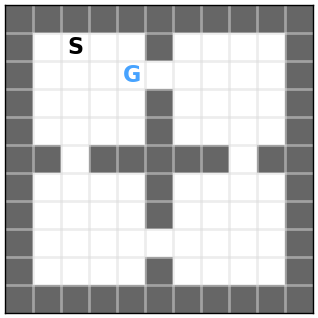

In [2]:
from envs.grid_custom.darkroom import DarkRoom

env = DarkRoom(grid_name='fourroom', terminate_on_goal=True) # use False during data collection
start_state, info = env.reset()
env.plot_grid()

[1 2]
[-1.  0.]
[1 2]
[1 2]


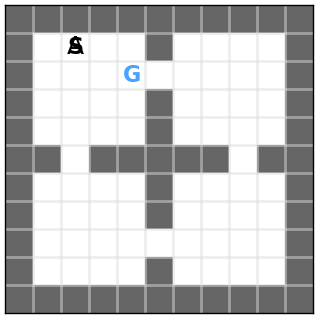

In [3]:
env.step(1)
env.render()